

# Project: Investigate TMDB Movie Dataset
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction


> TMDB Movie is a popular dataset contains valuable information about different movies and TV shows. For each movie the dataset shows a general information on it such as The Name, Genre , Cast and Director , also it shows movie's financial and rating data for an example Movie average rating, revenue, budget and popularity. Therefore the TMDB Movie dataset has been analyzed and explored in order to answer several questions and understand the data and its variables more. The questions that have been discussed are :

>1. Is there a relationship between movie's revenue and its popularity ?
>2. Do high average rated movies have more revenue ?
>3. Which decade has the highest movies average rate ?


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

<a id='wrangling'></a>
## Data Wrangling



### General Properties

In [54]:
data = pd.read_csv('tmdb-movies.csv') 
#   types and look for instances of missing or possibly errant data.
data.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

In [56]:
data.describe().round(2)

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.00,10866.00,1.086600e+04,1.086600e+04,10866.00,10866.00,10866.00,10866.00,1.086600e+04,1.086600e+04
mean,66064.18,0.65,1.462570e+07,3.982332e+07,102.07,217.39,5.97,2001.32,1.755104e+07,5.136436e+07
std,92130.14,1.00,3.091321e+07,1.170035e+08,31.38,575.62,0.94,12.81,3.430616e+07,1.446325e+08
min,5.00,0.00,0.000000e+00,0.000000e+00,0.00,10.00,1.50,1960.00,0.000000e+00,0.000000e+00
25%,10596.25,0.21,0.000000e+00,0.000000e+00,90.00,17.00,5.40,1995.00,0.000000e+00,0.000000e+00
50%,20669.00,0.38,0.000000e+00,0.000000e+00,99.00,38.00,6.00,2006.00,0.000000e+00,0.000000e+00
75%,75610.00,0.71,1.500000e+07,2.400000e+07,111.00,145.75,6.60,2011.00,2.085325e+07,3.369710e+07
max,417859.00,32.99,4.250000e+08,2.781506e+09,900.00,9767.00,9.20,2015.00,4.250000e+08,2.827124e+09


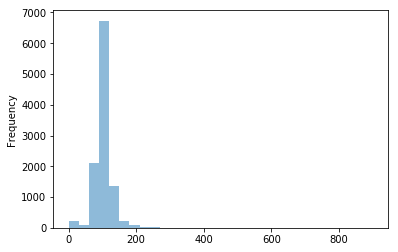

In [57]:
data['runtime'].plot(kind='hist',alpha=0.5,bins=30)

In [58]:
data[data['runtime'] <= 30]['runtime'].value_counts()

0     31
6     22
4     17
5     17
7     17
25    12
22    11
3     11
30    10
8      9
15     7
23     7
9      7
10     6
26     6
11     6
16     6
14     5
13     5
12     5
2      5
18     4
27     4
21     3
17     2
28     2
20     1
29     1
24     1
19     1
Name: runtime, dtype: int64

In [59]:
data.duplicated().value_counts()

False    10865
True         1
dtype: int64

### Data Quality Problems found:
    1. Change "vote_average" column name isnt descriptive
    2. "Popularity" column data has very high decimal place
    3. There are unneeded columns for analysis
    4. Null Values in columns ('Revenue','Budget' and 'Runtime')
    5. Many runtime values are not accurate (less than 10 min)
    6. 1 row is duplicated 

### Data Cleaning 

In [60]:
# Rename "Vote_average" column name to "average_rating" to more descriptive 
data.rename(columns = {"vote_average" : "average_rating"},inplace= True)

In [61]:
# Change popularity decimal place to be only 2 decimal places for better analysis 
data['popularity']= data.popularity.round(2)

In [62]:
# Remove uneeded columns 
data.columns
data.drop(columns=['id', 'imdb_id',
       'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview',
        'genres', 'production_companies', 'release_date',
        'budget_adj',
       'revenue_adj'],inplace=True)
                 
    

In [73]:
# Handling null values by using mean of the same columns
columns = ['revenue','budget','runtime']
for i in columns:
    mean = data[i].mean()
    data[i] = data[i].mask(data[i]==0,mean)

In [84]:
# Handling in accurate runtime values by multiplying it by 10
for i in range(len(data)):
    x = data['runtime'].iloc[i]
    if x <= 10 :
        data['runtime'].iloc[i] *= 10

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [91]:
# Handle Duplicates
data = data.drop_duplicates()

<a id='eda'></a>
## Exploratory Data Analysis


### Descriptive Analysis

In [92]:
data.describe().round(2)

,popularity,budget,revenue,runtime,vote_count,average_rating,release_year
count,10865.00,1.086500e+04,1.086500e+04,10865.00,10865.00,10865.00,10865.00
mean,0.65,2.229184e+07,6.187725e+07,102.89,217.40,5.98,2001.32
std,1.00,2.801364e+07,1.110239e+08,29.73,575.64,0.94,12.81
min,0.00,1.000000e+00,2.000000e+00,11.00,10.00,1.50,1960.00
25%,0.21,1.462570e+07,3.982332e+07,90.00,17.00,5.40,1995.00
50%,0.38,1.462570e+07,3.982332e+07,99.00,38.00,6.00,2006.00
75%,0.71,1.500000e+07,3.982332e+07,111.00,146.00,6.60,2011.00
max,32.99,4.250000e+08,2.781506e+09,900.00,9767.00,9.20,2015.00


In [93]:
data.corr()

,popularity,budget,revenue,runtime,vote_count,average_rating,release_year
popularity,1.000000,0.516020,0.635264,0.136283,0.800810,0.209533,0.089795
budget,0.516020,1.000000,0.705462,0.172193,0.615702,0.074241,0.129276
revenue,0.635264,0.705462,1.000000,0.143883,0.772944,0.152055,0.065170
runtime,0.136283,0.172193,0.143883,1.000000,0.164200,0.178267,-0.108655
vote_count,0.800810,0.615702,0.772944,0.164200,1.000000,0.253818,0.107962
average_rating,0.209533,0.074241,0.152055,0.178267,0.253818,1.000000,-0.117576
release_year,0.089795,0.129276,0.065170,-0.108655,0.107962,-0.117576,1.000000


### Is there a relationship between movie's revenue and its popularity ?

Text(0.5,1,'Revenue vs Popularity')

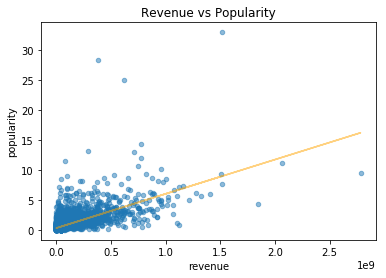

In [114]:
# Plot revenue against popularity 
y = data['popularity']
x = data['revenue']
m,b = np.polyfit(x,y,1)
data.plot(y='popularity',x= 'revenue',kind='scatter',alpha=0.5)
plt.plot(x,m*x+b,color='orange',alpha=0.5)
plt.title('Revenue vs Popularity')

#### Finding : 
There is a correlation between revenue and popularity with r = 0.66

### Do high rated movies have more revenue ?

In [95]:
# Grouping average_rating and create new column for it
bins = [1,3,5,7,10]
names = ['1-3','3-5','5-7','7-10']
data['rating_group'] = pd.cut(data['average_rating'],bins,labels=names)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Text(0.5,0,'Rating')

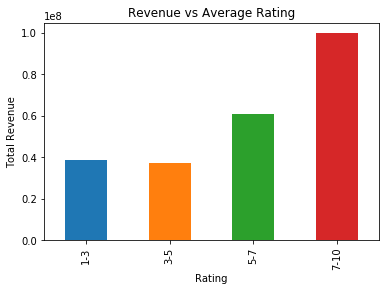

In [113]:
# Create bar chart for rating group vs average mean
plot1 = data.groupby('rating_group')['revenue'].mean().plot(kind='bar',title='Revenue vs Average Rating')
plot1.set_ylabel('Total Revenue')
plot1.set_xlabel('Rating')

#### Finding : 
Highly Rated movies from 7-10 have also the highest revenues and vice versa

### Which decade has the highest average movies rating ?

In [97]:
# Grouping release_years and create new column for it
bins_year = [1960,1970,1980,1990,2000,2010,2020]
names_year = ['1960-1970','1970-1980','1980-1990','1990-2000','2000-2010','2010-2020']
data['year_group'] = pd.cut(data['release_year'],bins_year,labels=names_year)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [98]:
data.head()

,popularity,budget,revenue,original_title,runtime,vote_count,average_rating,release_year,rating_group,year_group
0,32.99,150000000.0,1.513529e+09,Jurassic World,124.0,5562,6.5,2015,5-7,2010-2020
1,28.42,150000000.0,3.784364e+08,Mad Max: Fury Road,120.0,6185,7.1,2015,7-10,2010-2020
2,13.11,110000000.0,2.952382e+08,Insurgent,119.0,2480,6.3,2015,5-7,2010-2020
3,11.17,200000000.0,2.068178e+09,Star Wars: The Force Awakens,136.0,5292,7.5,2015,7-10,2010-2020
4,9.34,190000000.0,1.506249e+09,Furious 7,137.0,2947,7.3,2015,7-10,2010-2020


Text(0,0.5,'Ratings')

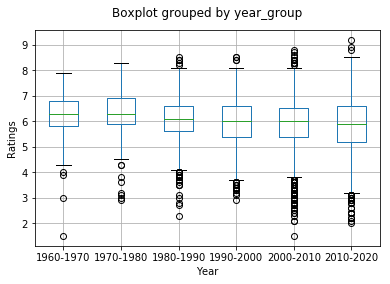

In [132]:
boxplot = data.boxplot(by= 'year_group',column= 'average_rating')
boxplot.set_title("")
boxplot.set_xlabel('Year')
boxplot.set_ylabel('Ratings')

#### Finding : 
There is a slight difference in average rating between old movies and recent movies. Years doesnt not affect the rating of the movies

<a id='conclusions'></a>
## Conclusions

> After finishing data exploration and analysis for answering all the asked questions. The analysis has shown that there is a correlation between both movie's revenue and its popularity with r= 0.66. Second the analysis proved that highly rated movies also has the highest average revenue.However there were some limitations in the data which could affect the results of the analysis as an example:

>>1. Many Null values in three main columns which was handled by replacing them by the mean of each column. The mean was used instead of the median because they were too many which cause the mean to be a zero. The handling process could improve the results but it would be more accurate if there werent any null values

>>2. Many Runtime column values are in accurate they were less than 10 mins which also could affect the                              results. They were handled by multipling them by 10
                    
>>3. Many Runtime column values are in accurate they were less than the regular average movie time and they couldnt be handled because they were more than 10 mins. It could be much better for the analysis if the movies were identifed as an example : Short movies, Short animated videos , cinematic movies , etc..... 

>Finally accroding to the graphical representation for release_year against average_rating  the earliest decades have slight  higher average rating median than the latest decades and also date doesnt not affect the rating of movies

## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [134]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0